# Extraction Subgraph Knowledge Graph from DRKG and SympGAN

## Libraries

In [2]:
import tarfile
import pandas as pd
import requests
import json
from tqdm import tqdm

## Retrieve DRKG Ontology

In [2]:
!wget -P drkg/ https://dgl-data.s3-us-west-2.amazonaws.com/dataset/DRKG/drkg.tar.gz

--2024-02-13 16:16:21--  https://dgl-data.s3-us-west-2.amazonaws.com/dataset/DRKG/drkg.tar.gz
Resolving dgl-data.s3-us-west-2.amazonaws.com (dgl-data.s3-us-west-2.amazonaws.com)... 3.5.83.142, 52.92.194.50, 3.5.77.190, ...
Connecting to dgl-data.s3-us-west-2.amazonaws.com (dgl-data.s3-us-west-2.amazonaws.com)|3.5.83.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 216650245 (207M) [application/x-tar]
Saving to: 'drkg/drkg.tar.gz.1'

     0K .......... .......... .......... .......... ..........  0%  248K 14m12s
    50K .......... .......... .......... .......... ..........  0%  254K 14m2s
   100K .......... .......... .......... .......... ..........  0%  252K 14m1s
   150K .......... .......... .......... .......... ..........  0% 32,1M 10m32s
   200K .......... .......... .......... .......... ..........  0%  500M 8m26s
   250K .......... .......... .......... .......... ..........  0%  366M 7m1s
   300K .......... .......... .......... .......... .......

In [4]:
# Replace 'your_file.tar.gz' with the actual file name
file_path = './drkg/drkg.tar.gz'

# Open the tar file
with tarfile.open(file_path, 'r:gz') as tar:
    # Extract all contents to the current working directory
    tar.extractall("./drkg")

In [7]:
drkg = pd.read_csv('./drkg/drkg.tsv', sep='\t')
drkg.head(10)

,Gene::2157,bioarx::HumGenHumGen:Gene:Gene,Gene::2157.1
0,Gene::2157,bioarx::HumGenHumGen:Gene:Gene,Gene::5264
1,Gene::2157,bioarx::HumGenHumGen:Gene:Gene,Gene::2158
2,Gene::2157,bioarx::HumGenHumGen:Gene:Gene,Gene::3309
3,Gene::2157,bioarx::HumGenHumGen:Gene:Gene,Gene::28912
4,Gene::2157,bioarx::HumGenHumGen:Gene:Gene,Gene::811
5,Gene::2157,bioarx::HumGenHumGen:Gene:Gene,Gene::2159
6,Gene::2157,bioarx::HumGenHumGen:Gene:Gene,Gene::821
7,Gene::2157,bioarx::HumGenHumGen:Gene:Gene,Gene::5627
8,Gene::2157,bioarx::HumGenHumGen:Gene:Gene,Gene::5624
9,Gene::2157,bioarx::HumGenHumGen:Gene:Gene,Gene::2147


## DRKG MetaGraph
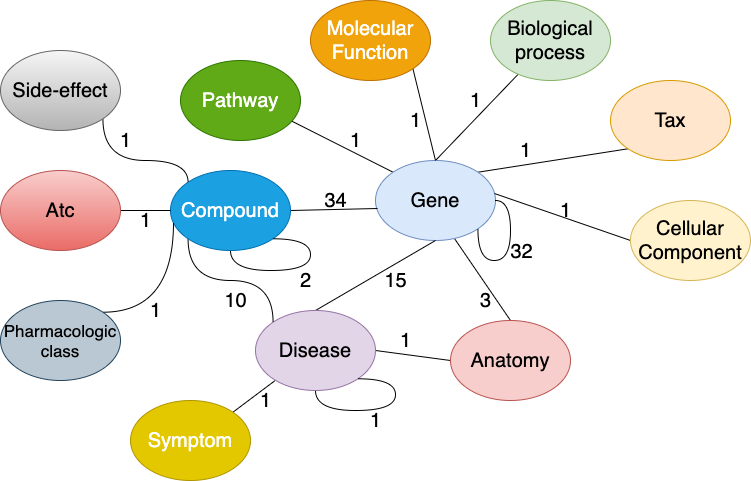

### Relation Types in DRKG

In [8]:
drkg['bioarx::HumGenHumGen:Gene:Gene'].unique()

array(['bioarx::HumGenHumGen:Gene:Gene', 'bioarx::VirGenHumGen:Gene:Gene',
       'bioarx::DrugVirGen:Compound:Gene',
       'bioarx::DrugHumGen:Compound:Gene',
       'bioarx::Covid2_acc_host_gene::Disease:Gene',
       'bioarx::Coronavirus_ass_host_gene::Disease:Gene',
       'DGIDB::INHIBITOR::Gene:Compound',
       'DGIDB::ANTAGONIST::Gene:Compound', 'DGIDB::OTHER::Gene:Compound',
       'DGIDB::AGONIST::Gene:Compound', 'DGIDB::BINDER::Gene:Compound',
       'DGIDB::MODULATOR::Gene:Compound', 'DGIDB::BLOCKER::Gene:Compound',
       'DGIDB::CHANNEL BLOCKER::Gene:Compound',
       'DGIDB::ANTIBODY::Gene:Compound',
       'DGIDB::POSITIVE ALLOSTERIC MODULATOR::Gene:Compound',
       'DGIDB::ALLOSTERIC MODULATOR::Gene:Compound',
       'DGIDB::ACTIVATOR::Gene:Compound',
       'DGIDB::PARTIAL AGONIST::Gene:Compound',
       'DRUGBANK::x-atc::Compound:Atc',
       'DRUGBANK::ddi-interactor-in::Compound:Compound',
       'DRUGBANK::target::Compound:Gene',
       'DRUGBANK::enzyme::Compou

## Extraction Disease-Symptom Subgraph

In [24]:
drkg_dis_symp = drkg[drkg['bioarx::HumGenHumGen:Gene:Gene'] == 'Hetionet::DpS::Disease:Symptom']
drkg_dis_symp.head(10)

,Gene::2157,bioarx::HumGenHumGen:Gene:Gene,Gene::2157.1
2591981,Disease::MESH:D017544,Hetionet::DpS::Disease:Symptom,Symptom::D007383
2591982,Disease::MESH:D009373,Hetionet::DpS::Disease:Symptom,Symptom::D021501
2591983,Disease::MESH:D001172,Hetionet::DpS::Disease:Symptom,Symptom::D010146
2591984,Disease::MESH:D001932,Hetionet::DpS::Disease:Symptom,Symptom::D013064
2591985,Disease::MESH:D008175,Hetionet::DpS::Disease:Symptom,Symptom::D003248
2591986,Disease::MESH:C562840,Hetionet::DpS::Disease:Symptom,Symptom::D059373
2591987,Disease::MESH:D018317,Hetionet::DpS::Disease:Symptom,Symptom::D009437
2591988,Disease::MESH:D007580,Hetionet::DpS::Disease:Symptom,Symptom::D006396
2591989,Disease::MESH:D009373,Hetionet::DpS::Disease:Symptom,Symptom::D004433
2591990,Disease::MESH:D008479,Hetionet::DpS::Disease:Symptom,Symptom::D006732


In [25]:
# Preprocessing DRKG Disease-Symptom data
for col in drkg_dis_symp.columns:
    drkg_dis_symp[col] = drkg_dis_symp[col].apply(lambda x: x.split('::')[2] if '::' in str(x) and len(x.split('::')) > 2 else x)

drkg_dis_symp.drop('bioarx::HumGenHumGen:Gene:Gene', axis=1, inplace=True)
drkg_dis_symp.head(10)

C:\Users\giuse\AppData\Local\Temp\ipykernel_10388\3716405592.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drkg_dis_symp[col] = drkg_dis_symp[col].apply(lambda x: x.split('::')[2] if '::' in str(x) and len(x.split('::')) > 2 else x)
C:\Users\giuse\AppData\Local\Temp\ipykernel_10388\3716405592.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drkg_dis_symp.drop('bioarx::HumGenHumGen:Gene:Gene', axis=1, inplace=True)


,Gene::2157,Gene::2157.1
2591981,Disease::MESH:D017544,Symptom::D007383
2591982,Disease::MESH:D009373,Symptom::D021501
2591983,Disease::MESH:D001172,Symptom::D010146
2591984,Disease::MESH:D001932,Symptom::D013064
2591985,Disease::MESH:D008175,Symptom::D003248
2591986,Disease::MESH:C562840,Symptom::D059373
2591987,Disease::MESH:D018317,Symptom::D009437
2591988,Disease::MESH:D007580,Symptom::D006396
2591989,Disease::MESH:D009373,Symptom::D004433
2591990,Disease::MESH:D008479,Symptom::D006732


In [26]:
# Modifica il DataFrame
drkg_dis_symp['Gene::2157'] = drkg_dis_symp['Gene::2157'].apply(lambda x: x.split('::')[-1])
drkg_dis_symp['Gene::2157'] = drkg_dis_symp['Gene::2157'].apply(lambda x: x.split(':')[-1])
drkg_dis_symp['Gene::2157.1'] = drkg_dis_symp['Gene::2157.1'].apply(lambda x: x.split('::')[-1])

drkg_dis_symp.head(10)

C:\Users\giuse\AppData\Local\Temp\ipykernel_10388\1196323482.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drkg_dis_symp['Gene::2157'] = drkg_dis_symp['Gene::2157'].apply(lambda x: x.split('::')[-1])
C:\Users\giuse\AppData\Local\Temp\ipykernel_10388\1196323482.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drkg_dis_symp['Gene::2157'] = drkg_dis_symp['Gene::2157'].apply(lambda x: x.split(':')[-1])
C:\Users\giuse\AppData\Local\Temp\ipykernel_10388\1196323482.py:4: SettingWithCopyWarning: 
A value i

,Gene::2157,Gene::2157.1
2591981,D017544,D007383
2591982,D009373,D021501
2591983,D001172,D010146
2591984,D001932,D013064
2591985,D008175,D003248
2591986,C562840,D059373
2591987,D018317,D009437
2591988,D007580,D006396
2591989,D009373,D004433
2591990,D008479,D006732


In [ ]:
session = requests.Session()

def converti_mesh_in_icd9cm(codice_mesh, api_key):
    url = f"https://uts-ws.nlm.nih.gov/rest/crosswalk/current/source/MSH/{codice_mesh}?targetSource=ICD9CM&apiKey={api_key}"

    response = session.get(url)

    if response.status_code == 200:
        data = json.loads(response.text)
        codici_icd9cm = [risultato["ui"] for risultato in data["result"]]
        # Prendi solo il primo risultato se ce ne sono più di uno
        return codici_icd9cm[0] if codici_icd9cm else None
    else:
        print(f"Errore nella chiamata API: {response.status_code}")
        return None

# Chiave API
api_key = "5ffff450-2c43-4fcd-808f-158cf91f14d2"  # Sostituisci con la tua chiave API

# Applica la conversione solo alle colonne specificate
for indice, riga in tqdm(drkg_dis_symp.iterrows(), total=len(drkg_dis_symp), desc="Conversione"):
    codice_mesh_1 = riga["Gene::2157"]
    codice_mesh_2 = riga["Gene::2157.1"]

    if isinstance(codice_mesh_1, str):
        codice_icd9cm_1 = converti_mesh_in_icd9cm(codice_mesh_1, api_key)
        drkg_dis_symp.at[indice, "Gene::2157"] = codice_icd9cm_1 if codice_icd9cm_1 else ""

    if isinstance(codice_mesh_2, str):
        codice_icd9cm_2 = converti_mesh_in_icd9cm(codice_mesh_2, api_key)
        drkg_dis_symp.at[indice, "Gene::2157.1"] = codice_icd9cm_2 if codice_icd9cm_2 else ""

Conversione: 100%|██████████| 3357/3357 [15:08<00:00,  3.70it/s]


In [ ]:
drkg_dis_symp.head(10)

,Gene::2157,Gene::2157.1
2591981,,
2591982,,
2591983,714.0,338-338.99
2591984,239.6,
2591985,,564.00
2591986,,611.71
2591987,,
2591988,152.1,578.0
2591989,,388.7
2591990,164.9,


In [ ]:
drkg_dis_symp_final = drkg_dis_symp[drkg_dis_symp['Gene::2157'] != ""]
drkg_dis_symp_final = drkg_dis_symp_final[drkg_dis_symp_final['Gene::2157.1'] != ""]

In [ ]:
drkg_dis_symp_final.head(10)

,Gene::2157,Gene::2157.1
2591983,714.0,338-338.99
2591988,152.1,578.0
2591993,161.9,786.05
2591996,151.9,787.1
2591997,340,333.4
...,...,...
2595326,556.9,789.00
2595329,179,789.00
2595331,295,317-319.99
2595332,710.0,287.0


In [ ]:
# Dividere la colonna 'Gene::2157' usando il trattino e ottenere la prima parte
drkg_dis_symp_final['Gene::2157'] = drkg_dis_symp_final['Gene::2157'].str.split('-', expand=True)[0]

# Dividere la colonna 'Gene::2157.1' usando il trattino e ottenere la prima parte
drkg_dis_symp_final['Gene::2157.1'] = drkg_dis_symp_final['Gene::2157.1'].str.split('-', expand=True)[0]

drkg_dis_symp_final.head(10)

In [ ]:
# Rimuovere i punti dalle colonne 'Gene::2157' e 'Gene::2157.1'
drkg_dis_symp_final['Gene::2157'] = drkg_dis_symp_final['Gene::2157'].str.replace('.', '')
drkg_dis_symp_final['Gene::2157.1'] = drkg_dis_symp_final['Gene::2157.1'].str.replace('.', '')

drkg_dis_symp_final.head(10)

<ipython-input-53-a8d453d3e02b>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_DS_filtered['Gene::2157'] = df_DS_filtered['Gene::2157'].str.replace('.', '')
<ipython-input-53-a8d453d3e02b>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_DS_filtered['Gene::2157.1'] = df_DS_filtered['Gene::2157.1'].str.replace('.', '')


,Gene::2157,Gene::2157.1
2591983,7140,338
2591988,1521,5780
2591993,1619,78605
2591996,1519,7871
2591997,340,3334
...,...,...
2595326,5569,78900
2595329,179,78900
2595331,295,317
2595332,7100,2870


In [ ]:
drkg_dis_symp_final.to_csv('./static_kg/DIAG_SYMP.csv', sep=",")

## Extraction Drug-Disease Subgraph

In [29]:
drkg_med_dis = drkg[drkg['bioarx::HumGenHumGen:Gene:Gene'] == 'DRUGBANK::treats::Compound:Disease']
drkg_med_dis.head(10)

,Gene::2157,bioarx::HumGenHumGen:Gene:Gene,Gene::2157.1
1518267,Compound::DB00003,DRUGBANK::treats::Compound:Disease,Disease::MESH:D003550
1518268,Compound::DB00004,DRUGBANK::treats::Compound:Disease,Disease::MESH:C063419
1518269,Compound::DB00005,DRUGBANK::treats::Compound:Disease,Disease::MESH:D013167
1518270,Compound::DB00005,DRUGBANK::treats::Compound:Disease,Disease::MESH:D006086
1518271,Compound::DB00005,DRUGBANK::treats::Compound:Disease,Disease::MESH:D017497
1518272,Compound::DB00005,DRUGBANK::treats::Compound:Disease,Disease::MESH:D001171
1518273,Compound::DB00005,DRUGBANK::treats::Compound:Disease,Disease::MESH:D011565
1518274,Compound::DB00005,DRUGBANK::treats::Compound:Disease,Disease::MESH:D015535
1518275,Compound::DB00005,DRUGBANK::treats::Compound:Disease,Disease::MESH:D017511
1518276,Compound::DB00005,DRUGBANK::treats::Compound:Disease,Disease::MESH:D001172


In [30]:
# Modifica il DataFrame
for col in drkg_med_dis.columns:
    drkg_med_dis[col] = drkg_med_dis[col].apply(lambda x: x.split('::')[2] if '::' in str(x) and len(x.split('::')) > 2 else x)

drkg_med_dis.drop('bioarx::HumGenHumGen:Gene:Gene', axis=1, inplace=True)
drkg_med_dis.head(10)

C:\Users\giuse\AppData\Local\Temp\ipykernel_10388\1450498267.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drkg_med_dis[col] = drkg_med_dis[col].apply(lambda x: x.split('::')[2] if '::' in str(x) and len(x.split('::')) > 2 else x)
C:\Users\giuse\AppData\Local\Temp\ipykernel_10388\1450498267.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drkg_med_dis.drop('bioarx::HumGenHumGen:Gene:Gene', axis=1, inplace=True)


,Gene::2157,Gene::2157.1
1518267,Compound::DB00003,Disease::MESH:D003550
1518268,Compound::DB00004,Disease::MESH:C063419
1518269,Compound::DB00005,Disease::MESH:D013167
1518270,Compound::DB00005,Disease::MESH:D006086
1518271,Compound::DB00005,Disease::MESH:D017497
1518272,Compound::DB00005,Disease::MESH:D001171
1518273,Compound::DB00005,Disease::MESH:D011565
1518274,Compound::DB00005,Disease::MESH:D015535
1518275,Compound::DB00005,Disease::MESH:D017511
1518276,Compound::DB00005,Disease::MESH:D001172


In [31]:
# Modifica il DataFrame
drkg_med_dis['Gene::2157'] = drkg_med_dis['Gene::2157'].apply(lambda x: x.split('::')[-1])
drkg_med_dis['Gene::2157.1'] = drkg_med_dis['Gene::2157.1'].apply(lambda x: x.split('::')[-1])
drkg_med_dis['Gene::2157.1'] = drkg_med_dis['Gene::2157.1'].apply(lambda x: x.split(':')[-1])

drkg_med_dis.head(10)

C:\Users\giuse\AppData\Local\Temp\ipykernel_10388\3752824560.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drkg_med_dis['Gene::2157'] = drkg_med_dis['Gene::2157'].apply(lambda x: x.split('::')[-1])
C:\Users\giuse\AppData\Local\Temp\ipykernel_10388\3752824560.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drkg_med_dis['Gene::2157.1'] = drkg_med_dis['Gene::2157.1'].apply(lambda x: x.split('::')[-1])
C:\Users\giuse\AppData\Local\Temp\ipykernel_10388\3752824560.py:4: SettingWithCopyWarning: 
A value 

,Gene::2157,Gene::2157.1
1518267,DB00003,D003550
1518268,DB00004,C063419
1518269,DB00005,D013167
1518270,DB00005,D006086
1518271,DB00005,D017497
1518272,DB00005,D001171
1518273,DB00005,D011565
1518274,DB00005,D015535
1518275,DB00005,D017511
1518276,DB00005,D001172


In [14]:
session = requests.Session()

def converti_drug_in_atc(codice_mesh, api_key):
    url = f"https://uts-ws.nlm.nih.gov/rest/crosswalk/current/source/DRUGBANK/{codice_mesh}?targetSource=ATC&apiKey={api_key}"

    response = session.get(url)

    if response.status_code == 200:
        data = json.loads(response.text)
        codici_atc = [risultato["ui"] for risultato in data["result"]]
        # Prendi solo il primo risultato se ce ne sono più di uno
        return codici_atc[0] if codici_atc else None
    else:
        print(f"Errore nella chiamata API: {response.status_code}")
        return None

# Chiave API
api_key = "5ffff450-2c43-4fcd-808f-158cf91f14d2"  # Sostituisci con la tua chiave API

# Applica la conversione solo alle colonne specificate
for indice, riga in tqdm(drkg_med_dis.iterrows(), total=len(drkg_med_dis), desc="Conversione"):
    codice_atc_1 = riga["Gene::2157"]

    if isinstance(codice_atc_1, str):
        codice_atc_1 = converti_drug_in_atc(codice_atc_1, api_key)
        drkg_med_dis.at[indice, "Gene::2157"] = codice_atc_1 if codice_atc_1 else ""

Conversione: 100%|██████████| 4968/4968 [11:29<00:00,  7.21it/s]


In [15]:
drkg_med_dis.head(50)

,Gene::2157,Gene::2157.1
1518267,R05CB13,D003550
1518268,L01XX29,C063419
1518269,L04AB01,D013167
1518270,L04AB01,D006086
1518271,L04AB01,D017497
1518272,L04AB01,D001171
1518273,L04AB01,D011565
1518274,L04AB01,D015535
1518275,L04AB01,D017511
1518276,L04AB01,D001172


In [16]:
session = requests.Session()

def converti_mesh_in_icd9cm(codice_mesh, api_key):
    url = f"https://uts-ws.nlm.nih.gov/rest/crosswalk/current/source/MSH/{codice_mesh}?targetSource=ICD9CM&apiKey={api_key}"

    response = session.get(url)

    if response.status_code == 200:
        data = json.loads(response.text)
        codici_icd9cm = [risultato["ui"] for risultato in data["result"]]
        # Prendi solo il primo risultato se ce ne sono più di uno
        return codici_icd9cm[0] if codici_icd9cm else None
    else:
        print(f"Errore nella chiamata API: {response.status_code}")
        return None

# Chiave API
api_key = "5ffff450-2c43-4fcd-808f-158cf91f14d2"  # Sostituisci con la tua chiave API

# Applica la conversione solo alle colonne specificate
for indice, riga in tqdm(drkg_med_dis.iterrows(), total=len(drkg_med_dis), desc="Conversione"):
    codice_mesh_2 = riga["Gene::2157.1"]

    if isinstance(codice_mesh_2, str):
        codice_icd9cm_2 = converti_mesh_in_icd9cm(codice_mesh_2, api_key)
        drkg_med_dis.at[indice, "Gene::2157.1"] = codice_icd9cm_2 if codice_icd9cm_2 else ""

Conversione: 100%|██████████| 4968/4968 [13:02<00:00,  6.35it/s]


In [17]:
drkg_med_dis.head(50)

,Gene::2157,Gene::2157.1
1518267,R05CB13,277.0
1518268,L01XX29,
1518269,L04AB01,720.0
1518270,L04AB01,279.50
1518271,L04AB01,
1518272,L04AB01,
1518273,L04AB01,
1518274,L04AB01,696.0
1518275,L04AB01,686.01
1518276,L04AB01,714.0


In [18]:
drkg_med_dis_final = drkg_med_dis[drkg_med_dis['Gene::2157'] != ""]
drkg_med_dis_final = drkg_med_dis_final[drkg_med_dis_final['Gene::2157.1'] != ""]

In [19]:
drkg_med_dis_final.head(10)

,Gene::2157,Gene::2157.1
1518267,R05CB13,277.0
1518269,L04AB01,720.0
1518270,L04AB01,279.50
1518274,L04AB01,696.0
1518275,L04AB01,686.01
...,...,...
1523222,L01EL03,200.4
1523225,N02CD04,346.0
1523226,N02CD04,346.1
1523229,V09IX09,209


In [20]:
# Dividere la colonna 'Gene::2157' usando il trattino e ottenere la prima parte
drkg_med_dis_final['Gene::2157'] = drkg_med_dis_final['Gene::2157'].str.split('-', expand=True)[0]

# Dividere la colonna 'Gene::2157.1' usando il trattino e ottenere la prima parte
drkg_med_dis_final['Gene::2157.1'] = drkg_med_dis_final['Gene::2157.1'].str.split('-', expand=True)[0]

# Rimuovere i punti dalle colonne 'Gene::2157' e 'Gene::2157.1'
drkg_med_dis_final['Gene::2157'] = drkg_med_dis_final['Gene::2157'].str.replace('.', '')
drkg_med_dis_final['Gene::2157.1'] = drkg_med_dis_final['Gene::2157.1'].str.replace('.', '')

drkg_med_dis_final.head(10)

<ipython-input-20-8d474a2d46c4>:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_CD_filtered['Gene::2157'] = df_CD_filtered['Gene::2157'].str.replace('.', '')
<ipython-input-20-8d474a2d46c4>:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_CD_filtered['Gene::2157.1'] = df_CD_filtered['Gene::2157.1'].str.replace('.', '')


,Gene::2157,Gene::2157.1
1518267,R05CB13,2770
1518269,L04AB01,7200
1518270,L04AB01,27950
1518274,L04AB01,6960
1518275,L04AB01,68601
...,...,...
1523222,L01EL03,2004
1523225,N02CD04,3460
1523226,N02CD04,3461
1523229,V09IX09,209


In [22]:
drkg_med_dis_final['Gene::2157'] = drkg_med_dis_final['Gene::2157'].astype(str).str[:5] #5 for level 4

In [23]:
drkg_med_dis_final.head(10)

,Gene::2157,Gene::2157.1
1518267,R05CB,2770
1518269,L04AB,7200
1518270,L04AB,27950
1518274,L04AB,6960
1518275,L04AB,68601
...,...,...
1523222,L01EL,2004
1523225,N02CD,3460
1523226,N02CD,3461
1523229,V09IX,209


In [24]:
drkg_med_dis_final.to_csv('./static_kg/DRUG_DIAG.csv', sep=",")

## Extraction Disease-Anatomy Subgraph

In [32]:
drkg_dis_ana = drkg[drkg['bioarx::HumGenHumGen:Gene:Gene'] == 'Hetionet::DlA::Disease:Anatomy']
drkg_dis_ana.head(10)

,Gene::2157,bioarx::HumGenHumGen:Gene:Gene,Gene::2157.1
2595338,Disease::MESH:D015209,Hetionet::DlA::Disease:Anatomy,Anatomy::UBERON:0002110
2595339,Disease::MESH:D024821,Hetionet::DlA::Disease:Anatomy,Anatomy::UBERON:0001980
2595340,Disease::MESH:D006258,Hetionet::DlA::Disease:Anatomy,Anatomy::UBERON:0001760
2595341,Disease::MESH:D018204,Hetionet::DlA::Disease:Anatomy,Anatomy::UBERON:0002360
2595342,Disease::MESH:D008180,Hetionet::DlA::Disease:Anatomy,Anatomy::UBERON:0002389
2595343,Disease::MESH:D000163,Hetionet::DlA::Disease:Anatomy,Anatomy::UBERON:0000178
2595344,Disease::MESH:D008881,Hetionet::DlA::Disease:Anatomy,Anatomy::UBERON:0000955
2595345,Disease::MESH:D008175,Hetionet::DlA::Disease:Anatomy,Anatomy::UBERON:0000977
2595346,Disease::MESH:D002532,Hetionet::DlA::Disease:Anatomy,Anatomy::UBERON:0002286
2595347,Disease::MESH:D004938,Hetionet::DlA::Disease:Anatomy,Anatomy::UBERON:0002040


In [33]:
# Modifica il DataFrame
for col in drkg_dis_ana.columns:
    drkg_dis_ana[col] = drkg_dis_ana[col].apply(lambda x: x.split('::')[2] if '::' in str(x) and len(x.split('::')) > 2 else x)

drkg_dis_ana.drop('bioarx::HumGenHumGen:Gene:Gene', axis=1, inplace=True)
drkg_dis_ana.head(10)

C:\Users\giuse\AppData\Local\Temp\ipykernel_10388\1449710579.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drkg_dis_ana[col] = drkg_dis_ana[col].apply(lambda x: x.split('::')[2] if '::' in str(x) and len(x.split('::')) > 2 else x)
C:\Users\giuse\AppData\Local\Temp\ipykernel_10388\1449710579.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drkg_dis_ana.drop('bioarx::HumGenHumGen:Gene:Gene', axis=1, inplace=True)


,Gene::2157,Gene::2157.1
2595338,Disease::MESH:D015209,Anatomy::UBERON:0002110
2595339,Disease::MESH:D024821,Anatomy::UBERON:0001980
2595340,Disease::MESH:D006258,Anatomy::UBERON:0001760
2595341,Disease::MESH:D018204,Anatomy::UBERON:0002360
2595342,Disease::MESH:D008180,Anatomy::UBERON:0002389
2595343,Disease::MESH:D000163,Anatomy::UBERON:0000178
2595344,Disease::MESH:D008881,Anatomy::UBERON:0000955
2595345,Disease::MESH:D008175,Anatomy::UBERON:0000977
2595346,Disease::MESH:D002532,Anatomy::UBERON:0002286
2595347,Disease::MESH:D004938,Anatomy::UBERON:0002040


In [34]:
# Modifica il DataFrame
drkg_dis_ana['Gene::2157'] = drkg_dis_ana['Gene::2157'].apply(lambda x: x.split('::')[-1])
drkg_dis_ana['Gene::2157'] = drkg_dis_ana['Gene::2157'].apply(lambda x: x.split(':')[-1])
drkg_dis_ana['Gene::2157.1'] = drkg_dis_ana['Gene::2157.1'].apply(lambda x: x.split('::')[-1])
drkg_dis_ana['Gene::2157.1'] = drkg_dis_ana['Gene::2157.1'].apply(lambda x: x.split(':')[-1])

drkg_dis_ana.head(10)

C:\Users\giuse\AppData\Local\Temp\ipykernel_10388\756529468.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drkg_dis_ana['Gene::2157'] = drkg_dis_ana['Gene::2157'].apply(lambda x: x.split('::')[-1])
C:\Users\giuse\AppData\Local\Temp\ipykernel_10388\756529468.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drkg_dis_ana['Gene::2157'] = drkg_dis_ana['Gene::2157'].apply(lambda x: x.split(':')[-1])
C:\Users\giuse\AppData\Local\Temp\ipykernel_10388\756529468.py:4: SettingWithCopyWarning: 
A value is tryin

,Gene::2157,Gene::2157.1
2595338,D015209,0002110
2595339,D024821,0001980
2595340,D006258,0001760
2595341,D018204,0002360
2595342,D008180,0002389
2595343,D000163,0000178
2595344,D008881,0000955
2595345,D008175,0000977
2595346,D002532,0002286
2595347,D004938,0002040


In [ ]:
session = requests.Session()

def converti_mesh_in_icd9cm(codice_mesh, api_key):
    url = f"https://uts-ws.nlm.nih.gov/rest/crosswalk/current/source/MSH/{codice_mesh}?targetSource=ICD9CM&apiKey={api_key}"

    response = session.get(url)

    if response.status_code == 200:
        data = json.loads(response.text)
        codici_icd9cm = [risultato["ui"] for risultato in data["result"]]
        # Prendi solo il primo risultato se ce ne sono più di uno
        return codici_icd9cm[0] if codici_icd9cm else None
    else:
        print(f"Errore nella chiamata API: {response.status_code}")
        return None

# Chiave API
api_key = "5ffff450-2c43-4fcd-808f-158cf91f14d2"  # Sostituisci con la tua chiave API

# Applica la conversione solo alle colonne specificate
for indice, riga in tqdm(drkg_dis_ana.iterrows(), total=len(drkg_dis_ana), desc="Conversione"):
    codice_mesh_2 = riga["Gene::2157"]

    if isinstance(codice_mesh_2, str):
        codice_icd9cm_2 = converti_mesh_in_icd9cm(codice_mesh_2, api_key)
        drkg_dis_ana.at[indice, "Gene::2157"] = codice_icd9cm_2 if codice_icd9cm_2 else ""

Conversione: 100%|██████████| 3602/3602 [07:16<00:00,  8.25it/s]


In [ ]:
drkg_dis_ana.head(50)

,Gene::2157,Gene::2157.1
2595338,,0002110
2595339,277.7,0001980
2595340,,0001760
2595341,,0002360
2595342,710.0,0002389
2595343,,0000178
2595344,346,0000955
2595345,,0000977
2595346,,0002286
2595347,150,0002040


In [ ]:
drkg_dis_ana_final = drkg_dis_ana[drkg_dis_ana['Gene::2157'] != ""]
drkg_dis_ana_final = drkg_dis_ana_final[drkg_dis_ana_final['Gene::2157.1'] != ""]

In [ ]:
drkg_dis_ana_final.head(10)

,Gene::2157,Gene::2157.1
2595339,277.7,0001980
2595342,710.0,0002389
2595344,346,0000955
2595347,150,0002040
2595351,295,0001893
...,...,...
2598933,299.0,0002298
2598936,556.9,0001183
2598937,190.9,0001677
2598938,585.9,0001814


In [ ]:
# Dividere la colonna 'Gene::2157' usando il trattino e ottenere la prima parte
drkg_dis_ana_final['Gene::2157'] = drkg_dis_ana_final['Gene::2157'].str.split('-', expand=True)[0]

# Dividere la colonna 'Gene::2157.1' usando il trattino e ottenere la prima parte
drkg_dis_ana_final['Gene::2157.1'] = drkg_dis_ana_final['Gene::2157.1'].str.split('-', expand=True)[0]

# Rimuovere i punti dalle colonne 'Gene::2157' e 'Gene::2157.1'
drkg_dis_ana_final['Gene::2157'] = drkg_dis_ana_final['Gene::2157'].str.replace('.', '')
drkg_dis_ana_final['Gene::2157.1'] = drkg_dis_ana_final['Gene::2157.1'].str.replace('.', '')

drkg_dis_ana_final.head(10)

<ipython-input-126-12a7ac15af23>:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_DA_filtered['Gene::2157'] = df_DA_filtered['Gene::2157'].str.replace('.', '')
<ipython-input-126-12a7ac15af23>:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_DA_filtered['Gene::2157.1'] = df_DA_filtered['Gene::2157.1'].str.replace('.', '')


,Gene::2157,Gene::2157.1
2595339,2777,0001980
2595342,7100,0002389
2595344,346,0000955
2595347,150,0002040
2595351,295,0001893
...,...,...
2598933,2990,0002298
2598936,5569,0001183
2598937,1909,0001677
2598938,5859,0001814


In [ ]:
drkg_dis_ana_final.to_csv('./static_kg/ANAT_DIAG.csv', sep=",")

## Extraction PharmacologicClass-Drug Subgraph

In [35]:
drkg_pharma_drug = drkg[drkg['bioarx::HumGenHumGen:Gene:Gene'] == 'Hetionet::PCiC::Pharmacologic Class:Compound']
drkg_pharma_drug.head(10)

,Gene::2157,bioarx::HumGenHumGen:Gene:Gene,Gene::2157.1
3002578,Pharmacologic Class::N0000175732,Hetionet::PCiC::Pharmacologic Class:Compound,Compound::DB00728
3002579,Pharmacologic Class::N0000185503,Hetionet::PCiC::Pharmacologic Class:Compound,Compound::DB05521
3002580,Pharmacologic Class::N0000191267,Hetionet::PCiC::Pharmacologic Class:Compound,Compound::DB00252
3002581,Pharmacologic Class::N0000181819,Hetionet::PCiC::Pharmacologic Class:Compound,Compound::DB00514
3002582,Pharmacologic Class::N0000175450,Hetionet::PCiC::Pharmacologic Class:Compound,Compound::DB00443
3002583,Pharmacologic Class::N0000007706,Hetionet::PCiC::Pharmacologic Class:Compound,Compound::DB00654
3002584,Pharmacologic Class::N0000175764,Hetionet::PCiC::Pharmacologic Class:Compound,Compound::DB00998
3002585,Pharmacologic Class::N0000171131,Hetionet::PCiC::Pharmacologic Class:Compound,Compound::DB01086
3002586,Pharmacologic Class::N0000185506,Hetionet::PCiC::Pharmacologic Class:Compound,Compound::DB08912
3002587,Pharmacologic Class::N0000007853,Hetionet::PCiC::Pharmacologic Class:Compound,Compound::DB00479


In [36]:
# Modifica il DataFrame
for col in drkg_pharma_drug.columns:
    drkg_pharma_drug[col] = drkg_pharma_drug[col].apply(lambda x: x.split('::')[2] if '::' in str(x) and len(x.split('::')) > 2 else x)

drkg_pharma_drug.drop('bioarx::HumGenHumGen:Gene:Gene', axis=1, inplace=True)
drkg_pharma_drug.head(10)

C:\Users\giuse\AppData\Local\Temp\ipykernel_10388\3238354006.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drkg_pharma_drug[col] = drkg_pharma_drug[col].apply(lambda x: x.split('::')[2] if '::' in str(x) and len(x.split('::')) > 2 else x)
C:\Users\giuse\AppData\Local\Temp\ipykernel_10388\3238354006.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drkg_pharma_drug.drop('bioarx::HumGenHumGen:Gene:Gene', axis=1, inplace=True)


,Gene::2157,Gene::2157.1
3002578,Pharmacologic Class::N0000175732,Compound::DB00728
3002579,Pharmacologic Class::N0000185503,Compound::DB05521
3002580,Pharmacologic Class::N0000191267,Compound::DB00252
3002581,Pharmacologic Class::N0000181819,Compound::DB00514
3002582,Pharmacologic Class::N0000175450,Compound::DB00443
3002583,Pharmacologic Class::N0000007706,Compound::DB00654
3002584,Pharmacologic Class::N0000175764,Compound::DB00998
3002585,Pharmacologic Class::N0000171131,Compound::DB01086
3002586,Pharmacologic Class::N0000185506,Compound::DB08912
3002587,Pharmacologic Class::N0000007853,Compound::DB00479


In [37]:
# Modifica il DataFrame
drkg_pharma_drug['Gene::2157'] = drkg_pharma_drug['Gene::2157'].apply(lambda x: x.split('::')[-1])
drkg_pharma_drug['Gene::2157.1'] = drkg_pharma_drug['Gene::2157.1'].apply(lambda x: x.split('::')[-1])

drkg_pharma_drug.head(10)

C:\Users\giuse\AppData\Local\Temp\ipykernel_10388\3586514196.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drkg_pharma_drug['Gene::2157'] = drkg_pharma_drug['Gene::2157'].apply(lambda x: x.split('::')[-1])
C:\Users\giuse\AppData\Local\Temp\ipykernel_10388\3586514196.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drkg_pharma_drug['Gene::2157.1'] = drkg_pharma_drug['Gene::2157.1'].apply(lambda x: x.split('::')[-1])


,Gene::2157,Gene::2157.1
3002578,N0000175732,DB00728
3002579,N0000185503,DB05521
3002580,N0000191267,DB00252
3002581,N0000181819,DB00514
3002582,N0000175450,DB00443
3002583,N0000007706,DB00654
3002584,N0000175764,DB00998
3002585,N0000171131,DB01086
3002586,N0000185506,DB08912
3002587,N0000007853,DB00479


In [14]:
session = requests.Session()

def converti_drug_in_atc(codice_mesh, api_key):
    url = f"https://uts-ws.nlm.nih.gov/rest/crosswalk/current/source/DRUGBANK/{codice_mesh}?targetSource=ATC&apiKey={api_key}"

    response = session.get(url)

    if response.status_code == 200:
        data = json.loads(response.text)
        codici_atc = [risultato["ui"] for risultato in data["result"]]
        # Prendi solo il primo risultato se ce ne sono più di uno
        return codici_atc[0] if codici_atc else None
    else:
        print(f"Errore nella chiamata API: {response.status_code}")
        return None

# Chiave API
api_key = "5ffff450-2c43-4fcd-808f-158cf91f14d2"  # Sostituisci con la tua chiave API

# Applica la conversione solo alle colonne specificate
for indice, riga in tqdm(drkg_pharma_drug.iterrows(), total=len(drkg_pharma_drug), desc="Conversione"):
    codice_atc_1 = riga["Gene::2157.1"]

    if isinstance(codice_atc_1, str):
        codice_atc_1 = converti_drug_in_atc(codice_atc_1, api_key)
        drkg_pharma_drug.at[indice, "Gene::2157.1"] = codice_atc_1 if codice_atc_1 else ""

Conversione: 100%|██████████| 1029/1029 [01:22<00:00, 12.52it/s]


In [15]:
drkg_pharma_drug.head(50)

,Gene::2157,Gene::2157.1
3002578,N0000175732,
3002579,N0000185503,J05AP02
3002580,N0000191267,N03AB02
3002581,N0000181819,R05DA09
3002582,N0000175450,S03BA03
3002583,N0000007706,S01EE01
3002584,N0000175764,N02CC07
3002585,N0000171131,C05AD03
3002586,N0000185506,L01EC02
3002587,N0000007853,D06AX12


In [16]:
drkg_pharma_drug_final = drkg_pharma_drug[drkg_pharma_drug['Gene::2157'] != ""]
drkg_pharma_drug_final = drkg_pharma_drug_final[drkg_pharma_drug_final['Gene::2157.1'] != ""]

In [17]:
drkg_pharma_drug_final.head(10)

,Gene::2157,Gene::2157.1
3002579,N0000185503,J05AP02
3002580,N0000191267,N03AB02
3002581,N0000181819,R05DA09
3002582,N0000175450,S03BA03
3002583,N0000007706,S01EE01
...,...,...
3003601,N0000008217,J02AC02
3003602,N0000187063,N03AB02
3003603,N0000175684,N02AA08
3003604,N0000011161,J01DD15


In [18]:
# Dividere la colonna 'Gene::2157' usando il trattino e ottenere la prima parte
drkg_pharma_drug_final['Gene::2157'] = drkg_pharma_drug_final['Gene::2157'].str.split('-', expand=True)[0]

# Dividere la colonna 'Gene::2157.1' usando il trattino e ottenere la prima parte
drkg_pharma_drug_final['Gene::2157.1'] = drkg_pharma_drug_final['Gene::2157.1'].str.split('-', expand=True)[0]

# Rimuovere i punti dalle colonne 'Gene::2157' e 'Gene::2157.1'
drkg_pharma_drug_final['Gene::2157'] = drkg_pharma_drug_final['Gene::2157'].str.replace('.', '')
drkg_pharma_drug_final['Gene::2157.1'] = drkg_pharma_drug_final['Gene::2157.1'].str.replace('.', '')

drkg_pharma_drug_final.head(10)

<ipython-input-18-4214631cb674>:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_DD_filtered['Gene::2157'] = df_DD_filtered['Gene::2157'].str.replace('.', '')
<ipython-input-18-4214631cb674>:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_DD_filtered['Gene::2157.1'] = df_DD_filtered['Gene::2157.1'].str.replace('.', '')


,Gene::2157,Gene::2157.1
3002579,N0000185503,J05AP02
3002580,N0000191267,N03AB02
3002581,N0000181819,R05DA09
3002582,N0000175450,S03BA03
3002583,N0000007706,S01EE01
...,...,...
3003601,N0000008217,J02AC02
3003602,N0000187063,N03AB02
3003603,N0000175684,N02AA08
3003604,N0000011161,J01DD15


In [19]:
drkg_pharma_drug_final['Gene::2157.1'] = drkg_pharma_drug_final['Gene::2157.1'].astype(str).str[:5] # 5 per level4 e 4 per level 3

In [20]:
drkg_pharma_drug_final.head(10)

,Gene::2157,Gene::2157.1
3002579,N0000185503,J05AP
3002580,N0000191267,N03AB
3002581,N0000181819,R05DA
3002582,N0000175450,S03BA
3002583,N0000007706,S01EE
...,...,...
3003601,N0000008217,J02AC
3003602,N0000187063,N03AB
3003603,N0000175684,N02AA
3003604,N0000011161,J01DD


In [21]:
drkg_pharma_drug_final.to_csv('./static_kg/PC_DRUG.csv', sep=",")

## Estrazione Symptom-Drug from SympGAN

In [3]:
# Specify the path to your text file
file_path = './sympgan/SympGAN_KG.txt'

# Read the data into a pandas DataFrame, skipping lines with errors
sympgan = pd.read_csv(file_path, sep="\t", header=None, error_bad_lines=False)
sympgan.columns = ['SOURCE', 'REL', 'DEST']

C:\Users\giuse\AppData\Local\Temp\ipykernel_10368\1750549593.py:5: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  sympgan = pd.read_csv(file_path, sep="\t", header=None, error_bad_lines=False)
Skipping line 91082: expected 3 fields, saw 5
Skipping line 227422: expected 3 fields, saw 4

Skipping line 409122: expected 3 fields, saw 5

Skipping line 542406: expected 3 fields, saw 4
Skipping line 713943: expected 3 fields, saw 4

Skipping line 842093: expected 3 fields, saw 5
Skipping line 922753: expected 3 fields, saw 4



In [4]:
sympgan_symp_drug = sympgan[sympgan['REL'] == 'sym_drug']
sympgan_symp_drug['DEST']

935640     DB00738
935641     DB06148
935642     DB01012
935643     DB00198
935644     DB00320
            ...   
1192982    DB00673
1192983    DB00765
1192984    DB01268
1192985    DB01073
1192986    DB00603
Name: DEST, Length: 123462, dtype: object

In [36]:
drkg_med_dis_final['Gene::2157']

1518267    DB00003
1518268    DB00004
1518269    DB00005
1518270    DB00005
1518271    DB00005
            ...   
1523230    DB15528
1523231    DB15566
1523232    DB15593
1523233    DB15595
1523234    DB15598
Name: Gene::2157, Length: 4968, dtype: object

In [37]:
sympgan_symp_drug = sympgan_symp_drug[sympgan_symp_drug['DEST'].isin(drkg_med_dis_final['Gene::2157'])]

In [38]:
sympgan_symp_drug.drop_duplicates() #se ne vanno la metà

,SOURCE,REL,DEST
935640,C0234215,sym_drug,DB00738
935642,C0011175,sym_drug,DB01012
935643,C0012833,sym_drug,DB00198
935644,C0085616,sym_drug,DB00320
935645,C0151828,sym_drug,DB00708
...,...,...,...
997366,C0687713,sym_drug,DB00673
997367,C0040034,sym_drug,DB00765
997368,C0020615,sym_drug,DB01268
997369,C1384666,sym_drug,DB01073


In [5]:
df_CUI_ICD = pd.read_csv('./sympgan/ICD9_CUI_mapping.csv')
df_CUI_ICD.head(10)

,Unnamed: 0,ICD9_Code,CUI,name
0,0,10.42,C0176199,Reconstruction of conjunctival cul-de-sac with...
1,1,10.49,C0176202,Other conjunctivoplasty
2,2,10.5,C0176203,Lysis of adhesions of conjunctiva and eyelid
3,3,10.9,C0175568,Other operations on conjunctiva
4,4,10.91,C0197180,Subconjunctival injection
5,5,11.00,NaN,NaN
6,6,11.39,C0176209,Other excision of pterygium
7,7,11.49,C0176212,Other removal or destruction of corneal lesion
8,8,11.52,C0197453,Repair of postoperative wound dehiscence of co...
9,9,11.63,C0197444,Penetrating keratoplasty with autograft


In [42]:
sympgan_cui_symp_drug = sympgan_symp_drug[sympgan_symp_drug['SOURCE'].isin(df_CUI_ICD['CUI'])]

In [43]:
sympgan_cui_symp_drug.drop_duplicates()

,SOURCE,REL,DEST
935642,C0011175,sym_drug,DB01012
935647,C0019079,sym_drug,DB00569
935657,C0008031,sym_drug,DB01215
935659,C0010520,sym_drug,DB00813
935662,C0000737,sym_drug,DB00494
...,...,...,...
997352,C0013404,sym_drug,DB01129
997356,C0008031,sym_drug,DB00338
997360,C0013604,sym_drug,DB00654
997367,C0040034,sym_drug,DB00765


In [44]:
# Esegui la mappatura utilizzando il metodo merge
sympgan_cui_symp_drug = pd.merge(sympgan_cui_symp_drug, df_CUI_ICD, left_on='SOURCE', right_on='CUI', how='left')

In [45]:
sympgan_cui_symp_drug.drop_duplicates(inplace=True)
len(sympgan_cui_symp_drug)

In [47]:
session = requests.Session()

def converti_drug_in_atc(codice_mesh, api_key):
    url = f"https://uts-ws.nlm.nih.gov/rest/crosswalk/current/source/DRUGBANK/{codice_mesh}?targetSource=ATC&apiKey={api_key}"

    response = session.get(url)

    if response.status_code == 200:
        data = json.loads(response.text)
        codici_atc = [risultato["ui"] for risultato in data["result"]]
        # Prendi solo il primo risultato se ce ne sono più di uno
        return codici_atc[0] if codici_atc else None
    else:
        print(f"Errore nella chiamata API: {response.status_code}")
        return None

# Chiave API
api_key = "5ffff450-2c43-4fcd-808f-158cf91f14d2"  # Sostituisci con la tua chiave API

# Applica la conversione solo alle colonne specificate
for indice, riga in tqdm(sympgan_cui_symp_drug.iterrows(), total=len(sympgan_cui_symp_drug), desc="Conversione"):
    codice_atc_1 = riga["DEST"]

    if isinstance(codice_atc_1, str):
        codice_atc_1 = converti_drug_in_atc(codice_atc_1, api_key)
        sympgan_cui_symp_drug.at[indice, "DEST"] = codice_atc_1 if codice_atc_1 else ""

Conversione: 100%|██████████| 10011/10011 [13:41<00:00, 12.18it/s]


In [48]:
sympgan_cui_symp_drug.head(50)

,SOURCE,REL,DEST,Unnamed: 0,ICD9_Code,CUI,name
0,C0011175,sym_drug,H05BX01,206,276.51,C0011175,Dehydration
1,C0019079,sym_drug,B01AX05,1217,786.3,C0019079,Hemoptysis
2,C0008031,sym_drug,N05CD04,1218,786.50,C0008031,"Chest pain, unspecified"
3,C0010520,sym_drug,N01AH01,1201,782.5,C0010520,Cyanosis
4,C0000737,sym_drug,N04BX02,1231,789.00,C0000737,"Abdominal pain, unspecified site"
...,...,...,...,...,...,...,...
10006,C0013404,sym_drug,A02BC04,1215,786.05,C0013404,Shortness of breath
10007,C0008031,sym_drug,A02BC01,1218,786.50,C0008031,"Chest pain, unspecified"
10008,C0013604,sym_drug,S01EE01,1199,782.3,C0013604,Edema
10009,C0040034,sym_drug,C02KB01,231,287.5,C0040034,"Thrombocytopenia, unspecified"


In [49]:
columns_to_remove = ['SOURCE', 'REL', 'CUI', 'Unnamed: 0', 'name']
sympgan_cui_symp_drug.drop(columns=columns_to_remove, inplace=True)

In [50]:
new_column_order = ['ICD9_Code', 'DEST']

# Selezionare e riordinare le colonne
sympgan_cui_symp_drug = sympgan_cui_symp_drug[new_column_order]

In [51]:
sympgan_cui_symp_drug.head(10)

,ICD9_Code,DEST
0,276.51,H05BX01
1,786.3,B01AX05
2,786.50,N05CD04
3,782.5,N01AH01
4,789.00,N04BX02
...,...,...
10006,786.05,A02BC04
10007,786.50,A02BC01
10008,782.3,S01EE01
10009,287.5,C02KB01


In [52]:
sympgan_cui_symp_drug_final = sympgan_cui_symp_drug[sympgan_cui_symp_drug['ICD9_Code'] != ""]
sympgan_cui_symp_drug_final = sympgan_cui_symp_drug_final[sympgan_cui_symp_drug_final['DEST'] != ""]

In [53]:
sympgan_cui_symp_drug_final['DEST'] = sympgan_cui_symp_drug_final['DEST'].astype(str).str[:5] # 5 for level4 and 4 for level 3

In [ ]:
sympgan_cui_symp_drug_final['ICD9_Code'] = sympgan_cui_symp_drug_final['ICD9_Code'].str.replace('.', '')
sympgan_cui_symp_drug_final.head(10)

In [55]:
sympgan_cui_symp_drug_final.to_csv('./static_kg/SYMP_DRUG.csv', sep=",")